# Basics of Working with the Unusable Data Mask (UDM)

The [Unusable Data Mask (UDM) File](https://www.planet.com/docs/spec-sheets/sat-imagery/#72-unusable-data-mask-file) is provided with many Planet products. It provides pixel-by-pixel information on quality issues that may affect the usability of each pixel, depending on the application.

In this notebook, we demonstrate visualizing and converting the UDM to a binary mask, for use in masking the corresponding Planet scene.

The UDM is an 8-bit single-band image. Pixel quality issues are bit-encoded. For example, if Bit 0 is set to 1 for a pixel in the UDM, then the pixel is in an area that was not imaged by the spacecraft, and the pixel is 'blackfill'. If all bits are set to zero, there is no quality issue with the pixel. 

The UDM is basically a classified image, where the binary representation provides the bit-encoded quality information. Therefore, we visualize the UDM as such.

How we convert a UDM to a mask depends on which quality issues we are concerned about. If we require no quality issues, then we mask out all pixels that have a non-zero value (any bits set to 1). However, if we have our own cloud detection algorithm and do not want to exclude pixels that are suspected to be cloud covered, then we mask out all pixels that have bits other than Bit 1 (cloud-covered) set to 1.

## Install Dependencies and Set up Notebook

In [4]:
import os
import subprocess

## Download UDM

To download the udm, we use the planet CLI because it handles activating, waiting for activation, and downloading the file.

We will save the udm in the `data` folder. This folder isn't tracked by git so the downloaded image file will not bloat our git repository.

In [18]:
# create the data folder if it doesn't exist
data_folder = 'data'
if not os.path.isdir(data_folder): os.mkdir(data_folder)

In [19]:
!planet data download --item-type PSOrthoTile \
                      --asset-type udm \
                      --string-in id 210879_1558814_2016-07-25_0e16 \
                      --dest data

activating: 0            complete: 0              elapsed: 0                    
paging: False            pending: 0                                             

activating: 1            complete: 0              downloaded: 0.00MB            
downloading: 0           elapsed: 1               paging: True                  
pending: 0                                                                      

activating: 0            complete: 0              downloaded: 0.00MB            
downloading: 0           elapsed: 2               paging: False                 
pending: 1                                                                      

activating: 0            complete: 0              downloaded: 0.00MB            
downloading: 1           elapsed: 3               paging: False                 
pending: 0                                                                      

activating: 0            complete: 0              downloaded: 0.00MB            
downloading: 1          

In [24]:
# store the udm filename for processing and make sure the file exists
udm_filename = os.path.join('data', '210879_1558814_2016-07-25_0e16_BGRN_DN_udm.tif')
print(udm_filename)
assert os.path.isfile(udm_filename)

data/210879_1558814_2016-07-25_0e16_BGRN_DN_udm.tif


## Visualize UDM

Since the UDM is bit-encoded, its scale is not linear. In fact, each unique value represents a unique quality classification. Therefore, we will treat it as a classified image. To visualize the UDM as a classified image, we will first define some utility functions for visualizing a classified band with matplotlib.

In [17]:
# Utility functions: visualizing a classified band

def plot_classified_band(class_band, class_labels=None, cmap='rainbow',
                         title='Class Labels', figdim=10):
    fig = plt.figure(figsize=(figdim, figdim))
    ax = fig.add_subplot(1, 1, 1)
    imshow_class_band(ax, class_band, class_labels, cmap=cmap)
    ax.set_title(title)
    ax.set_axis_off()

def imshow_class_band(ax, class_band, class_labels=None, cmap='rainbow'):
    """Show classified band with colormap normalization and color legend. Alters ax in place.
    
    possible cmaps ref: https://matplotlib.org/examples/color/colormaps_reference.html
    """
    class_norm = _ClassNormalize(class_band)
    im = ax.imshow(class_band, cmap=cmap, norm=class_norm)

    try:
        # add class label legend
        # https://stackoverflow.com/questions/25482876
        # /how-to-add-legend-to-imshow-in-matplotlib
        color_mapping = class_norm.mapping
        colors = [im.cmap(color_mapping[k]) for k in class_labels.keys()]
        labels = class_labels.values()

        # https://matplotlib.org/users/legend_guide.html
        # tag: #creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
        patches = [mpatches.Patch(color=c, label=l) for c,l in zip(colors, labels)]

        ax.legend(handles=patches, bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.)
    except AttributeError:
        # class_labels not specified
        pass

# https://matplotlib.org/users/colormapnorms.html#custom-normalization-two-linear-ranges
class _ClassNormalize(colors.Normalize):
    """Matplotlib colormap normalizer for a classified band."""
    def __init__(self, arry):
        # get unique unmasked values
        values = [v for v in np.unique(arry)
                  if not isinstance(v, np.ma.core.MaskedConstant)]

        color_ticks = np.array(range(len(values)), dtype=np.float) / (len(values) - 1)
        self._mapping = dict((v, ct)
                            for v, ct in zip(values, color_ticks))
        
        # Initialize base Normalize instance
        vmin = 0
        vmax = 1
        clip = False
        colors.Normalize.__init__(self, vmin, vmax, clip)
    
    def __call__(self, arry, clip=None):
        # round array back to ints for logical comparison
        arry = np.around(arry)
        new_arry = arry.copy()
        for k, v in self._mapping.items():
            new_arry[arry==k] = v
        return new_arry
    
    @property
    def mapping(self):
        return self._mapping

In [42]:
import matplotlib
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


%matplotlib inline

In [43]:
from collections import OrderedDict

import rasterio
import numpy as np

In [46]:
# Utility functions for loading a UDM image and identifying binary representation as class labels
def load_udm(udm_filename):
    '''Load single-band bit-encoded UDM as a 2D array.'''
    with rasterio.open(udm_filename, 'r') as src:
        udm = src.read()[0,...]
    return udm

def get_udm_labels(udm):
    '''Get the binary representation of the UDM values'''
    return OrderedDict((v, '{0:b}'.format(v)) for v in np.unique(udm))

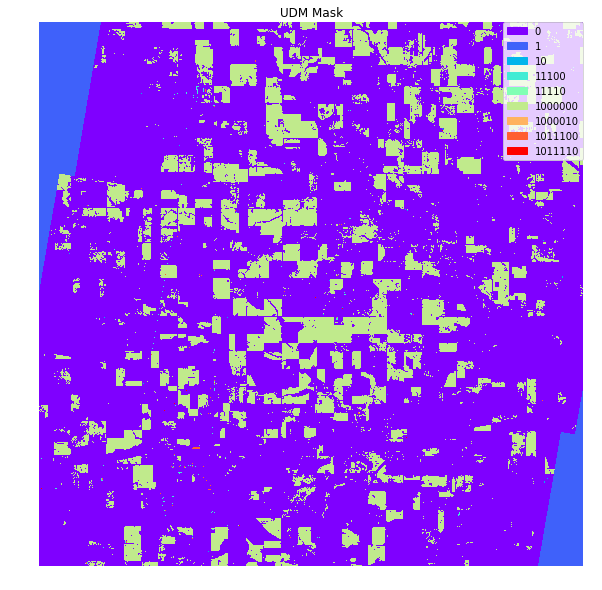

In [47]:
udm = load_udm(udm_filename)
udm_labels = get_udm_labels(udm)
plot_classified_band(udm, class_labels=udm_labels, title='UDM Mask')